#### Here we used resnet-9 model to train our model
#### Dataset Link : https://www.kaggle.com/datasets/msambare/fer2013

In [1]:
import os
import torch
import numpy as np
import matplotlib.pyplot as plt
import random

In [2]:
data_dir = "./data"


### Data Augmentation

In [3]:
from torchvision.datasets import ImageFolder
import torchvision.transforms as tt
import torchvision

train_tfms = tt.Compose([
                    tt.RandomHorizontalFlip(p = 0.5),
                    tt.ToTensor(),
    ])

val_tfms = tt.Compose([tt.ToTensor()])

#retriving the images from the folders and assigned them with a label
train_ds = ImageFolder(data_dir+'/train',train_tfms)
val_ds = ImageFolder(data_dir+'/test',val_tfms)


#Creating batches (To load data into batches)
from torch.utils.data import DataLoader
batch_size = 32
train_dl = DataLoader(train_ds,batch_size,shuffle=True,num_workers=2,pin_memory=True)
val_dl = DataLoader(val_ds,batch_size,shuffle=True,num_workers=2,pin_memory=True)

### For GPU

In [4]:
##################################### for GPU ###########################

def get_default_device():
    # pick the gpu if available
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')

def to_device(data,device):
    #move tensors to choosen device
    if isinstance(data,(list,tuple)):
        return [to_device(x,device) for x in data]
    return data.to(device,non_blocking = True)


class DeviceDataLoader():
    # move the batches of the data to our selected device
    def __init__(self,dl,device):
        self.dl = dl
        self.device = device
    def __iter__(self):
        for b in self.dl:
            yield to_device(b, self.device)
    def __len__(self):
        return len(self.dl)

device = get_default_device()

train_loader = DeviceDataLoader(train_dl, device)
val_loader = DeviceDataLoader(val_dl, device)

#########################################################################

In [5]:
for x,y in train_loader:
    print(x.shape)
    print(y.shape)
    break

torch.Size([32, 3, 48, 48])
torch.Size([32])


### Check results on a few select images

In [5]:
class_labels=['Angry','Disgust', 'Fear', 'Happy','Neutral','Sad','Surprise']
# x,y = next(iter(train_loader))
# y = y.cpu()

In [7]:
# n=random.randint(0, x.shape[0] - 1)
# image = x[n]
# orig_labl = class_labels[y[n]]
# plt.imshow(np.moveaxis(image.cpu().numpy(),0,-1))
# plt.title("Original label is : "+orig_labl)
# plt.show()

In [8]:
# n=random.randint(0, x.shape[0] - 1)
# image = x[n]
# orig_labl = class_labels[y[n]]
# plt.imshow(np.moveaxis(image.cpu().numpy(),0,-1))
# plt.title("Original label is : "+orig_labl)
# plt.show()

## Defining the model

In [6]:
import torch.nn as nn
import torch.nn.functional as fn

class Residual(nn.Module):
    def __init__(self, channels: int):
        super().__init__()
        self.conv1 = nn.Conv2d(channels, channels, 3, padding=(1, 1))
        self.conv1_bn = nn.BatchNorm2d(channels)
        self.conv2 = nn.Conv2d(channels, channels, 3, padding=(1, 1))
        self.conv2_bn = nn.BatchNorm2d(channels)

    def forward(self, x):
        out = self.conv1(x)
        out = self.conv1_bn(out)
        out = fn.leaky_relu(out, negative_slope=0.1)
        out = self.conv2(out)
        out = self.conv2_bn(out)
        out = fn.leaky_relu(out, negative_slope=0.1)
        return out

class ResNet9(nn.Module):
    def __init__(self, input_size,classes):
        super().__init__()
        self.conv0 = nn.Conv2d(input_size, 64, 3, padding=(1, 1))
        self.conv0_bn = nn.BatchNorm2d(64, momentum=0.8)
        self.conv1 = nn.Conv2d(64, 128, 3, padding=(1, 1))
        self.conv1_bn = nn.BatchNorm2d(128, momentum=0.8)
        self.residual1 = Residual(128)
        self.conv2 = nn.Conv2d(128, 256, 3, padding=(1, 1))
        self.conv2_bn = nn.BatchNorm2d(256, momentum=0.8)
        self.residual2 = Residual(256)
        self.conv3 = nn.Conv2d(256, 512, 3, padding=(1, 1))
        self.conv3_bn = nn.BatchNorm2d(512, momentum=0.8)
        self.residual3 = Residual(512)
        self.fc1 = nn.Linear(512, classes)

    def forward(self, x):
        # prep layer
        x = self.conv0(x)
        x = self.conv0_bn(x)
        x = fn.leaky_relu(x, negative_slope=0.1)
        # layer 1
        x = self.conv1(x)
        x = fn.max_pool2d(x, 2)
        x = self.conv1_bn(x)
        x = fn.leaky_relu(x, negative_slope=0.1)
        x = x + self.residual1(x)
        # layer 2
        x = self.conv2(x)
        x = fn.max_pool2d(x, 2)
        x = self.conv2_bn(x)
        x = fn.leaky_relu(x, negative_slope=0.1)
        x = x + self.residual2(x)
        # layer 3
        x = self.conv3(x)
        x = fn.max_pool2d(x, 2)
        x = self.conv3_bn(x)
        x = fn.leaky_relu(x, negative_slope=0.1)
        x = x + self.residual3(x)
        # layer 4
        x = nn.AdaptiveMaxPool2d((1, 1))(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = fn.softmax(x, dim=-1)
        return x

In [7]:
train_losses = []
val_losses = []
metrics = []
lrs = []

def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

def loss_batch(model,loss_fn,xb,yb,sched,opt=None,metric=None,grad_clip = None):
    # perform for every batch of data
    # calculate loss
    pred = model(xb)
    loss = loss_fn(pred, yb)
    #we keep optimizer as optional because we will use this function to evaluate validation set
    #and there we don't need optimizer
    if opt is not None:
        #compute gradient
        loss.backward()
        # Gradient clipping
        if grad_clip: 
            nn.utils.clip_grad_value_(model.parameters(), grad_clip)
        #update weights
        opt.step()
        #reset gradients
        opt.zero_grad()
        
        # Record & update learning rate
        lrs.append(get_lr(opt))
        sched.step()
        
    
    metric_result = None
    if metric is not None:
        #compute the metric
        metric_result = metric(pred,yb)    
    return loss.item(),len(xb),metric_result

def evaluate(model,loss_fn,valid_dl,grad_clip,sched,metric=None):
    with torch.no_grad():   #because we don't want to compute gradient for this
        #pass each batch through the model
        results = [loss_batch(model, loss_fn, xb, yb,sched,metric = metric)
                   for xb,yb in valid_dl]
        losses,nums,metrics = zip(*results)
        #total size of the datasets
        total = np.sum(nums)
        #average loss over the batches
        avg_loss = np.sum(np.multiply(losses,nums))/total
        avg_metric = None
        if metric is not None:
            #avg of metric across batches
            avg_metric = np.sum(np.multiply(metrics,nums))/total
    return avg_loss,total,avg_metric 

def accuracy(outputs,labels):
    _,preds = torch.max(outputs,dim = 1)
    return torch.sum(preds == labels).item()/len(preds)


def fit(epochs,model,loss_fn,opt,train_dl,valid_dl,grad_clip,sched,metric=None):

    for epoch in range(epochs):
        #Training
        model.train()
        for xb,yb in train_dl:
            loss,_,_ = loss_batch(model, loss_fn, xb, yb,sched,opt,grad_clip = grad_clip)
        
        #Evaluation
        model.eval()
        result = evaluate(model, loss_fn, valid_dl,grad_clip,sched,metric)
        val_loss,total,val_metric = result
        
        #keep track of all loss and metric
        train_losses.append(loss)
        val_losses.append(val_loss)
        
        metrics.append(val_metric)
        #print progress
        #print(epoch," accuracy : ",metrics)
        if metric is None:
            print('Epoch [{}/{}],Loss: {:.4f}'.format(epoch+1,epochs,val_loss))
        else:
            print('Epoch [{}/{}],Loss: {:.4f}, {}: {:.4f}'
                  .format(epoch+1,epochs,val_loss,metric.__name__,val_metric))


In [8]:
epochs = 100
max_lr = 0.01
grad_clip = 0.1
weight_decay = 1e-4


### Setting up model, optimizer and loss function

In [9]:
model = to_device(ResNet9(3,7),device)
# Set up cutom optimizer with weight decay
optimizer = torch.optim.Adam(model.parameters(), lr=max_lr,weight_decay=weight_decay)
# Set up one-cycle learning rate scheduler
sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs=epochs, 
                                                steps_per_epoch=len(train_loader))

#loss function (Cross Entropy)
loss_fn = fn.cross_entropy 


#### Training the model

In [13]:
fit(epochs,model,loss_fn,optimizer,train_loader,val_loader,grad_clip,sched,accuracy)

Epoch [1/100],Loss: 1.8125, accuracy: 0.3399
Epoch [2/100],Loss: 1.7953, accuracy: 0.3540
Epoch [3/100],Loss: 1.7216, accuracy: 0.4351
Epoch [4/100],Loss: 1.7544, accuracy: 0.4003
Epoch [5/100],Loss: 1.7295, accuracy: 0.4270
Epoch [6/100],Loss: 1.7302, accuracy: 0.4277
Epoch [7/100],Loss: 1.7447, accuracy: 0.4147
Epoch [8/100],Loss: 1.7536, accuracy: 0.4055
Epoch [9/100],Loss: 1.7643, accuracy: 0.3951
Epoch [10/100],Loss: 1.7482, accuracy: 0.4096
Epoch [11/100],Loss: 1.7003, accuracy: 0.4590
Epoch [12/100],Loss: 1.6608, accuracy: 0.4982
Epoch [13/100],Loss: 1.6536, accuracy: 0.5047
Epoch [14/100],Loss: 1.6783, accuracy: 0.4829
Epoch [15/100],Loss: 1.6825, accuracy: 0.4769
Epoch [16/100],Loss: 1.6483, accuracy: 0.5118
Epoch [17/100],Loss: 1.6444, accuracy: 0.5146
Epoch [18/100],Loss: 1.6770, accuracy: 0.4822
Epoch [19/100],Loss: 1.6783, accuracy: 0.4790
Epoch [20/100],Loss: 1.7549, accuracy: 0.4035
Epoch [21/100],Loss: 1.6761, accuracy: 0.4847
Epoch [22/100],Loss: 1.6752, accuracy: 0.48

#### plotting the graph (Accurecy)

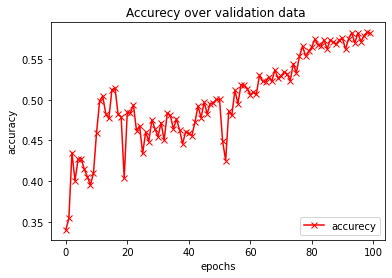

In [14]:
plt.plot(metrics,'-xr')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.title("Accurecy over validation data ")
plt.legend(["accurecy"],loc ="lower right")
plt.show()

#### plotting the graph (loss)

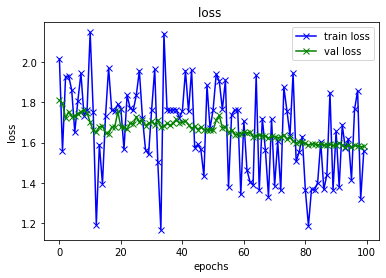

In [15]:
plt.plot(train_losses,'-xb')
plt.plot(val_losses,'-xg')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.title("loss ")
plt.legend(["train loss","val loss"])
plt.show()

#### visualize how the learning rate changed over time, batch-by-batch over all the epochs

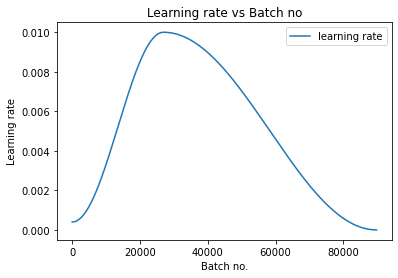

In [16]:
plt.plot(lrs)
plt.xlabel("Batch no.")
plt.ylabel("Learning rate")
plt.title("Learning rate vs Batch no")
plt.legend(["learning rate"])
plt.show()

## Save the model

In [17]:
torch.save(model.state_dict(),"face_detection_resnet_9_pytorch_100")

## Load model

In [10]:
model = ResNet9(3,7)
model.load_state_dict(torch.load("./face_detection_pytorch_30"))
model.to(device)


ResNet9(
  (conv0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv0_bn): BatchNorm2d(64, eps=1e-05, momentum=0.8, affine=True, track_running_stats=True)
  (conv1): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv1_bn): BatchNorm2d(128, eps=1e-05, momentum=0.8, affine=True, track_running_stats=True)
  (residual1): Residual(
    (conv1): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv1_bn): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv2_bn): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv2): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2_bn): BatchNorm2d(256, eps=1e-05, momentum=0.8, affine=True, track_running_stats=True)
  (residual2): Residual(
    (conv1): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1),

### Confusion Matrix - verify accuracy of each class

In [11]:
from sklearn import metrics
from sklearn.metrics import confusion_matrix
import seaborn as sns

### Accuracy and Confusion-Matrix for some batches

Accuracy =  0.71875


<AxesSubplot:>

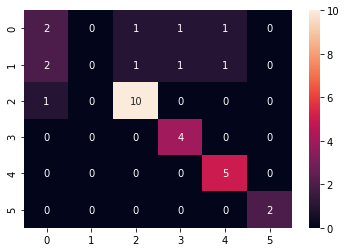

In [59]:
x,test_labels = next(iter(val_loader))
test_labels = test_labels.cpu()
predictions = model(x).to('cpu').detach().numpy()
predictions = np.argmax(predictions, axis=1)
print ("Accuracy = ", metrics.accuracy_score(test_labels, predictions))
cm = confusion_matrix(test_labels, predictions)
sns.heatmap(cm, annot=True)

Accuracy =  0.5625


<AxesSubplot:>

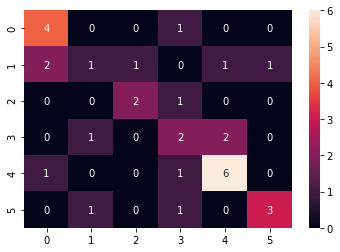

In [63]:
x,test_labels = next(iter(val_loader))
test_labels = test_labels.cpu()
predictions = model(x).to('cpu').detach().numpy()
predictions = np.argmax(predictions, axis=1)
print ("Accuracy = ", metrics.accuracy_score(test_labels, predictions))
cm = confusion_matrix(test_labels, predictions)
sns.heatmap(cm, annot=True)

### Check results on a few select images

In [15]:
x,y = next(iter(val_loader))
y = y.cpu()

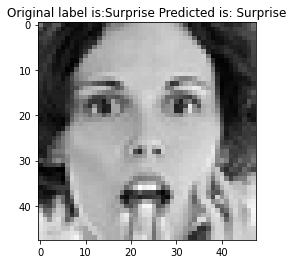

In [48]:
n=random.randint(0, x.shape[0] - 1)
image = x[n]
predictions = model(x).to('cpu').detach().numpy()
predictions = np.argmax(predictions, axis=1)
orig_labl = class_labels[y[n]]
pred_labl = class_labels[predictions[n]]
plt.imshow(np.moveaxis(image.cpu().numpy(),0,-1))
plt.title("Original label is:"+orig_labl+" Predicted is: "+ pred_labl)
plt.show()

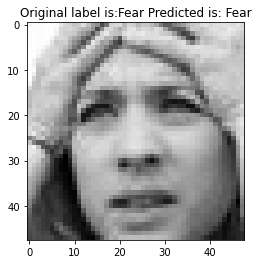

In [52]:
n=random.randint(0, x.shape[0] - 1)
image = x[n]
predictions = model(x).to('cpu').detach().numpy()
predictions = np.argmax(predictions, axis=1)
orig_labl = class_labels[y[n]]
pred_labl = class_labels[predictions[n]]
plt.imshow(np.moveaxis(image.cpu().numpy(),0,-1))
plt.title("Original label is:"+orig_labl+" Predicted is: "+ pred_labl)
plt.show()

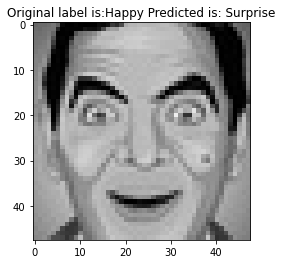

In [58]:
n=random.randint(0, x.shape[0] - 1)
image = x[n]
predictions = model(x).to('cpu').detach().numpy()
predictions = np.argmax(predictions, axis=1)
orig_labl = class_labels[y[n]]
pred_labl = class_labels[predictions[n]]
plt.imshow(np.moveaxis(image.cpu().numpy(),0,-1))
plt.title("Original label is:"+orig_labl+" Predicted is: "+ pred_labl)
plt.show()